In [1]:
require 'unsup';
require 'nn';
require 'gnuplot';
require 'ComplexAutoencoder/src/Encoder';
require 'ComplexAutoencoder/src/Decoder';
require 'nngraph';
require 'image';
require 'optim';
require 'randomkit'

In [2]:
n_hidden = 50
n_input = 32*32

In [3]:
t = torch.Timer()
train = torch.load('mnist.t7/train_32x32.t7', 'ascii')
test = torch.load('mnist.t7/test_32x32.t7', 'ascii')
train = train.data

traindata = torch.Tensor(train:size()[1],1,32,32)
for i = 1,train:size()[1] do   
   traindata[i] = train[i]
end
traindata:div(traindata:std())
--traindata:add(-traindata:mean())
print(t:time().real)

0.38901019096375	


In [4]:


enc1 = nn.Encoder(1,50,7,5e-4)
enc2 = nn.Encoder(50,10,7,5e-4)
dec = nn.Decoder(10,1,7)
autoencoder = nn.Sequential()
autoencoder:add(enc1)
autoencoder:add(enc2)
autoencoder:add(dec)
enc1:evaluate()
--autoencoder = torch.load('ComplexAutoencoder/model2400.net')

0.077839136123657	


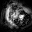

In [5]:
 activity = traindata[9001]
local phase = torch.Tensor(1,32,32):zero()
inp = {torch.cmul(activity,torch.cos(phase)),torch.cmul(activity,torch.sin(phase))}

t = torch.Timer()
local out = autoencoder:forward(inp)
print(t:time().real)
local a = torch.sqrt( torch.pow(out[1],2) + torch.pow(out[2],2 ))
local phase_out = torch.atan2(out[2],out[1])
itorch.image(a)

In [6]:
test = nn.ParallelTable()
test:add(nn.SpatialLPPooling(50, 1, 7, 7))
test:add(nn.SpatialLPPooling(50, 1, 7, 7))
a = test:forward(enc1:forward(inp))
res = nn.ParallelTable()
res:add(nn.Reshape(50*4*4))
res:add(nn.Reshape(50*4*4))
b = res:forward(a)
print(nn.Linear(50*4*4,10):forward(b[1]))
--print(autoencoder,:get(1).encoder:get(1):get(1):get(1):get(2):get(2).weight)

 -1.6558
 13.3994
  1.9002
 26.1809
-10.2688
  7.9171
-13.3144
 16.0415
 12.6859
  4.0018
[torch.DoubleTensor of size 10]



In [12]:
test = enc1:clone()
test:evaluate()
print(test)

nn.Encoder
{
  encoder : 
    nn.Sequential {
      [input -> (1) -> (2) -> (3) -> (4) -> (5) -> output]
      (1): nn.ConcatTable {
        input
          |`-> (1): nn.Sequential {
          |      [input -> (1) -> (2) -> output]
          |      (1): nn.ParallelTable {
          |        input
          |          |`-> (1): nn.Sequential {
          |          |      [input -> (1) -> (2) -> output]
          |          |      (1): nn.SpatialZeroPadding(l=3,r=3,t=3,b=3)
          |          |      (2): nn.SpatialConvolution(1 -> 50, 7x7)
          |          |    }
          |          |`-> (2): nn.Sequential {
          |          |      [input -> (1) -> (2) -> output]
          |          |      (1): nn.SpatialZeroPadding(l=3,r=3,t=3,b=3)
          |          |      (2): nn.SpatialConvolution(1 -> 50, 7x7)
          |          |    }
          |           ... -> output
          |      }
          |      (2): nn.ConcatTable {
          |        input
          |          |`-> (1): 

  1 : 
            nn.ConcatTable {
              input
                |`-> (1): nn.Sequential {
                |      [input -> (1) -> (2) -> output]
                |      (1): nn.ParallelTable {
                |        input
                |          |`-> (1): nn.Sequential {
                |          |      [input -> (1) -> (2) -> output]
                |          |      (1): nn.SpatialZeroPadding(l=3,r=3,t=3,b=3)
                |          |      (2): nn.SpatialConvolution(1 -> 50, 7x7)
                |          |    }
                |          |`-> (2): nn.Sequential {
                |          |      [input -> (1) -> (2) -> output]
                |          |      (1): nn.SpatialZeroPadding(l=3,r=3,t=3,b=3)
                |          |      (2): nn.SpatialConvolution(1 -> 50, 7x7)
                |          |    }
                |           ... -> output
                |      }
                |      (2): nn.ConcatTable {
                |        input
              

 nn.CAddTable
  (3): nn.Sqrt
  (4): nn.Sequential {
    [input -> (1) -> (2) -> output]
    (1): nn.SpatialZeroPadding(l=3,r=3,t=3,b=3)
    (2): nn.SpatialConvolution(1 -> 50, 7x7)
  }
  (5): nn.MulConstant
}
                }
              train : false
              output : 
                {
                  1 : table: 0x40cc6888
                  2 : DoubleTensor - size: 50x32x32
                }
            }
          2 : 
            nn.FlattenTable
            {
              gradInput : table: 0x40ccabc0
              input_map : 
                {
                  1 : table: 0x40ccac70
                  2 : 3
                }
              train : false
              output : 
                {
                  1 : DoubleTensor - size: 50x32x32
                  2 : DoubleTensor - size: 50x32x32
                  3 : DoubleTensor - size: 50x32x32
                }
            }
          3 : 
            nn.ConcatTable {
              input
                |`-> (1): nn.

ity
       ... -> output
  }
  (2): nn.CMulTable
}
                  2 : nn.Sequential {
  [input -> (1) -> (2) -> output]
  (1): nn.ParallelTable {
    input
      |`-> (1): nn.Sin
      |`-> (2): nn.Identity
       ... -> output
  }
  (2): nn.CMulTable
}
                }
              train : false
              output : 
                {
                  1 : DoubleTensor - size: 50x32x32
                  2 : DoubleTensor - size: 50x32x32
                }
            }
        }
      train : false
      output : 
        {
          1 : DoubleTensor - size: 50x32x32
          2 : DoubleTensor - size: 50x32x32
        }
    }
  input : 1
  output : 
    {
      1 : DoubleTensor - size: 50x32x32
      2 : DoubleTensor - size: 50x32x32
    }
  gradInput : DoubleTensor - empty
  kernel_size : 7
  hidden : 50
  lpenalty : 0.0005
}


In [15]:
if 0 then print('a') end

a	
